# NYC Subway Dataset Analysis

## Assignment

Purpose of this assignment is to analyze subway ridership dataset and see if external elements like rain significantly influence the number of passengers.  
Also, we need to predict number of passengers based on parameters we previously analyzed.

## Disclaimers

Part of the this assigment are also questions in Problem Sets 2, 3, and 4 in the Introduction to Data Science course.  
I have resolved all of those.  
On couple of them, server would return some unrelated errors and my submission would fail even though I did get required plots.  
This only happens when dealing with ggplot.

## Loading Data and Defining Functions

## Section 0. References

1. Udacity "Intro to Data Science" videos
2. pandas, numpy, sklearn, ggplot documentation
3. http://matplotlib.org/users/pyplot_tutorial.html
4. http://matplotlib.org/examples/api/barchart_demo.html
5. https://www.youtube.com/watch?v=pHrwqLhAaMw
6. http://stackoverflow.com/questions/2546016/how-to-define-fill-colours-in-ggplot-histogram
7. https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test

## Section 1. Statistical Test

### Question 1.1
Which statistical test did you use to analyze the NYC subway data? Did you use a one-tail or a two-tail P value? What is the null hypothesis? What is your p-critical value?

#### Answer
**H0: P(x_rain > y_no_rain) = P(y_no_rain > x_rain) = 0.5**  
Probability of taking observation (ENTRIESn_hourly) from the rain data which is greater than observation from no rain data equals 0.5  
**H1: P(x_rain > y_no_rain) ≠ P(y_no_rain > x_rain) ≠ 0.5**  
Probability of taking observation (ENTRIESn_hourly) from the rain data which is greater than observation from no rain data is not equal to 0.5  
  
I am using two-tail p value.

p_critical = 0.05  
  
I used Mann-Whitney u-test since the data is not normally distributed.

#### Calculation
First we separate *entries* into cases when it rains and when it doesn't rain.

In [196]:
import numpy as np
import pandas
import pandasql
from sklearn.linear_model import SGDRegressor
import scipy
from ggplot import *
%matplotlib inline 

pandas.set_option('display.max_columns', None)
data = pandas.read_csv('data/weather.csv')

In [197]:
data_rain = data["ENTRIESn_hourly"][data.rain == 1]
data_no_rain = data["ENTRIESn_hourly"][data.rain == 0]

Now we can compare entries on the days that it rains vs. the ones when it doesn't. 
  
To detect which test we should use we first need to confirm or deny some assumptions we have about data.  
We'll use Shapiro-Wilk test to see weather our data is normally distributed.

In [198]:
w,p_rain = scipy.stats.shapiro(data_rains)
print "p_rains = " + str(p_rain)

w,p_no_rain = scipy.stats.shapiro(data_no_rain)
print "p_no_rain = " + str(p_no_rain)

p_rains = 0.0
p_no_rain = 0.0


As both p values are equal to 0.0 we can conclude that our data is not normally distributed.  
Because of that Mann-Whitney u-test seems appropriate to compare data samples.  
This test doesn't assume any particular probability distribution.

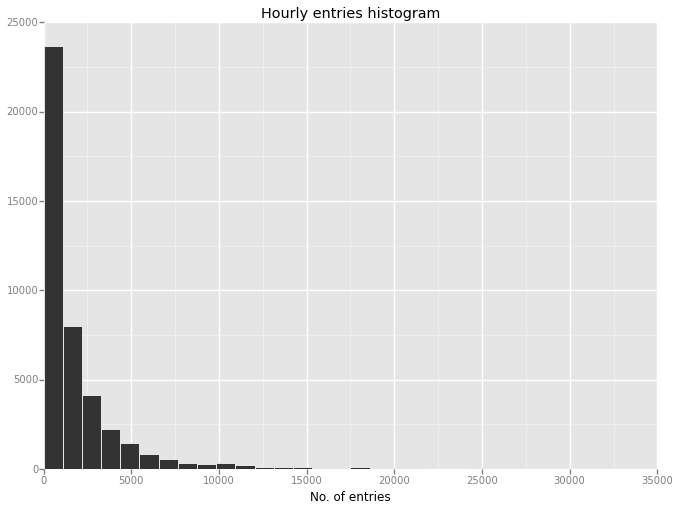

<ggplot: (8789790055709)>

In [199]:
ggplot(data, aes(x="ENTRIESn_hourly")) + geom_histogram() + \
ggtitle("Hourly entries histogram") + \
xlab('No. of entries')

Histogram above shows the distribution of hourly entries.  
We can see that most of the time ridership is relatively low and high ridership is infrequent.

### Question 1.2
Why is this statistical test applicable to the dataset? In particular, consider the assumptions that the test is making about the distribution of ridership in the two samples.

#### Answer
Mann-Whitney u-test doesn't assume any particular sample distribution which makes it suitable for this data set which is not normally distributed.

### Question 1.3
What results did you get from this statistical test? These should include the following numerical values: p-values, as well as the means for each of the two samples under test.

#### Answer
Calculating p value for our Mann-Whitney u-test:

In [200]:
u,p = scipy.stats.mannwhitneyu(data_rains, data_no_rain)
two_tail_test_multiplier = 2.0
print 'p = ' + str(p * two_tail_test_multiplier)
print "entries_mean_weekday_rains_ridership = " + str(np.mean(data_rains))
print "entries_mean_weekday_no_rain_ridership = " + str(np.mean(data_no_rain))
#print data.iloc[0]

p = 5.48213914249e-06
entries_mean_weekday_rains_ridership = 2028.19603547
entries_mean_weekday_no_rain_ridership = 1845.53943866


Calculated p value is lower than our p critical value (0.05) which suggests rain has significant impact on ridership on weekdays.

### Question 1.4
What is the significance and interpretation of these results?

#### Answer
Statistical significance of these results is 0.05  
Calculated p value from Mann-Whitney u-test is lower than p critical value.  
Based on this calculation H0 hypothesis is rejected and we can conclude that rain has significant impact on ridership.

## Section 2. Linear Regression

### Question 2.1
What approach did you use to compute the coefficients theta and produce prediction for ENTRIESn_hourly in your regression model:
- OLS using Statsmodels or Scikit Learn
- Gradient descent using Scikit Learn
- Or something different?

#### Answer
I used gradient descent from scikit learn.

### Question 2.2
What features (input variables) did you use in your model? Did you use any dummy variables as part of your features?

#### Answer
In my model I used the following variables (all of them as dummy variables):
- UNIT
- hour
- day_week

#### Calculation

In [201]:
def linear_regression(features, values):
    model = SGDRegressor()
    model.fit(features, values)

    intercept = model.intercept_
    params = model.coef_
    
    return intercept, params

In [202]:
def normalize_features(features):
    ''' 
    Returns the means and standard deviations of the given features, along with a normalized feature
    matrix.
    ''' 
    means = np.mean(features, axis=0)
    std_devs = np.std(features, axis=0)
    normalized_features = (features - means) / std_devs
    
    return means, std_devs, normalized_features

In [203]:
def recover_params(means, std_devs, norm_intercept, norm_params):
    ''' 
    Recovers the weights for a linear model given parameters that were fitted using
    normalized features. Takes the means and standard deviations of the original
    features, along with the intercept and parameters computed using the normalized
    features, and returns the intercept and parameters that correspond to the original
    features.
    ''' 
    intercept = norm_intercept - np.sum(means * norm_params / std_devs)
    params = norm_params / std_devs
    
    return intercept, params

In [204]:
def compute_r_squared(data, predicted_data):
    
    y = data['ENTRIESn_hourly'].tolist()
    avg_y = np.mean(y)
    
    
    top_diff = y - predicted_data
    top_diff_squared = top_diff * top_diff
    top_total_sum = np.sum(top_diff_squared)
    
    bottom_diff = y - avg_y
    bottom_diff_squared = bottom_diff * bottom_diff
    bottom_total_sum = np.sum(bottom_diff_squared)
    
    r_squared = 1 - (top_total_sum / bottom_total_sum)
    
    
    return r_squared

In [205]:
def predictions(dataframe): 
    
    features = pandas.get_dummies(dataframe['UNIT'], prefix='unit')
    dummy_units = pandas.get_dummies(dataframe['day_week'], prefix='day_week')
    features = features.join(dummy_units)
    dummy_units = pandas.get_dummies(dataframe['hour'], prefix='hour')
    features = features.join(dummy_units)
    
    
    #print dummy_units
    
    # Values
    values = dataframe['ENTRIESn_hourly']
    
    # Get numpy arrays
    features_array = features.values
    values_array = values.values
    
    means, std_devs, normalized_features_array = normalize_features(features_array)

    # Perform gradient descent
    norm_intercept, norm_params = linear_regression(normalized_features_array, values_array)
    
    intercept, params = recover_params(means, std_devs, norm_intercept, norm_params)
    
    predictions = intercept + np.dot(features_array, params)
    # The following line would be equivalent:
    # predictions = norm_intercept + np.dot(normalized_features_array, norm_params)
    
    global data_intercept
    data_intercept = intercept
    
    global data_params
    data_params = params
    
    return predictions

In [206]:
data_intercept = []
data_params = []
entries_predictions = predictions(data)

r_squared = compute_r_squared(data, entries_predictions)
print "r_squared: " + str(r_squared)
#print data.iloc[0]

r_squared: 0.522371338512


### Question 2.3
Why did you select these features in your model? We are looking for specific reasons that lead you to believe that
the selected features will contribute to the predictive power of your model.
- Your reasons might be based on intuition. For example, response for fog might be: “I decided to use fog because I thought that when it is very foggy outside people might decide to use the subway more often.”
- Your reasons might also be based on data exploration and experimentation, for example: “I used feature X because as soon as I included it in my model, it drastically improved my R2 value.”

#### Answer

Feature selection was based both on data analysis and experimentation.  
  
Variables based on analysis:
- weekday (which later turned out to be redundant to day_week variable)
  
Features based on experimentation and incresasing R^2 value:
- hour
- day_week


### Question 2.4
What are the parameters (also known as "coefficients" or "weights") of the non-dummy features in your linear regression model?

#### Answer
This model only uses dummy features so there are no coefficients for non-dummy features.

### Question 2.5
What is your model’s R2 (coefficients of determination) value?

#### Answer

In [207]:
print "R^2 coefficient: " + str(r_squared)

R^2 coefficient: 0.522371338512


### Question 2.6
What does this R2 value mean for the goodness of fit for your regression model? Do you think this linear model to predict ridership is appropriate for this dataset, given this R2  value?

#### Answer
Our R^2 value is roughtly 0.5  
This means that our model managed to account for or explain 50% of the variability found in the data (hourly entries).  

This model could be further improved either by using some other (non-linear) model and / or by including some more data which is not currently in the dataset. Example would be: was there a sports event on specific date and how far is the stadium from this station etc. 

## Section 3. Visualization

Please include two visualizations that show the relationships between two or more variables in the NYC subway data.
Remember to add appropriate titles and axes labels to your plots. Also, please add a short description below each figure commenting on the key insights depicted in the figure.

### Question 3.1
One visualization should contain two histograms: one of  ENTRIESn_hourly for rainy days and one of ENTRIESn_hourly for non-rainy days.
- You can combine the two histograms in a single plot or you can use two separate plots.
- If you decide to use to two separate plots for the two histograms, please ensure that the x-axis limits for both of the plots are identical. It is much easier to compare the two in that case.
- For the histograms, you should have intervals representing the volume of ridership (value of ENTRIESn_hourly) on the x-axis and the frequency of occurrence on the y-axis. For example, each interval (along the x-axis), the height of the bar for this interval will represent the number of records (rows in our data) that have ENTRIESn_hourly that falls in this interval.
- Remember to increase the number of bins in the histogram (by having larger number of bars). The default bin width is not sufficient to capture the variability in the two samples.

#### Answer

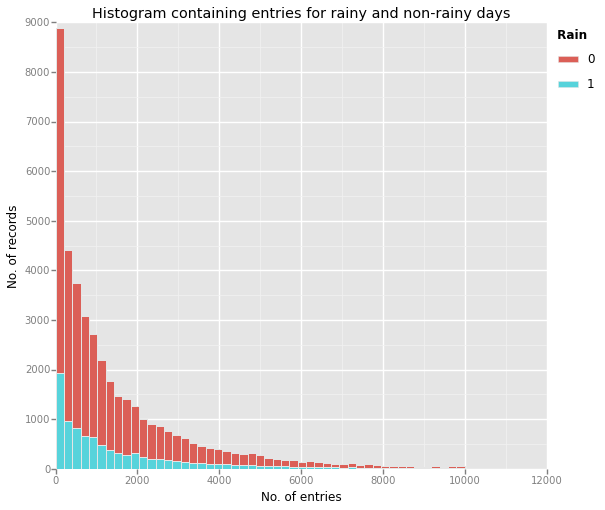

<ggplot: (8789789694897)>

In [208]:
ggplot(data[data['ENTRIESn_hourly'] < 10000], aes(x="ENTRIESn_hourly", fill="rain")) + geom_histogram(binwidth=200) + \
ggtitle("Histogram containing entries for rainy and non-rainy days") + \
xlab('No. of entries') + ylab('No. of records')

In the diagram above we can see that ridership distribution is pretty similar on the days when it rans as the one when it doesn't rain.  
Also we can see that rain entries are less frequent than non-rain entries.

### Question 3.2
One visualization can be more freeform. You should feel free to implement something that we discussed in class (e.g., scatter plots, line plots) or attempt to implement something more advanced if you'd like. Some suggestions are:
- Ridership by time-of-day
- Ridership by day-of-week

#### Answer

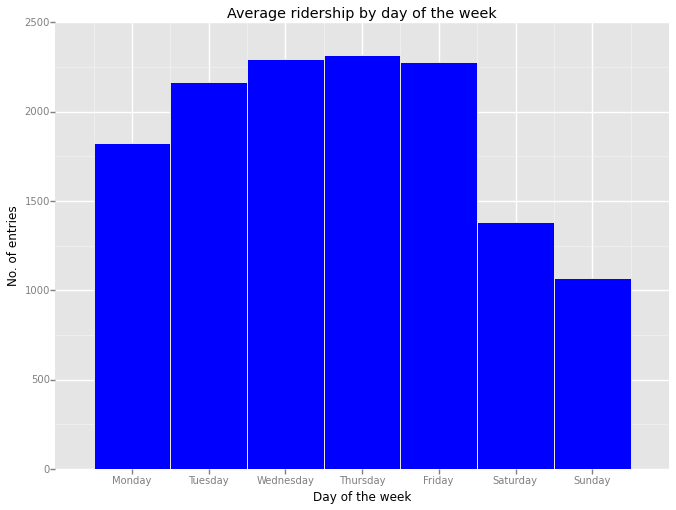

<ggplot: (8789790246205)>

In [209]:
q = """
select day_week, avg(ENTRIESn_hourly) as entries
from data
group by day_week
"""

day_of_week_data = pandasql.sqldf(q, locals())

ggplot(day_of_week_data, aes("day_week", "entries")) + geom_bar(stat="bar", fill="blue") + \
ggtitle('Average ridership by day of the week') + \
ylab('No. of entries') + xlab('Day of the week') + \
scale_x_continuous(breaks=range(0,7), labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

In the figure above we can see that average ridership is much lower during the weekend.

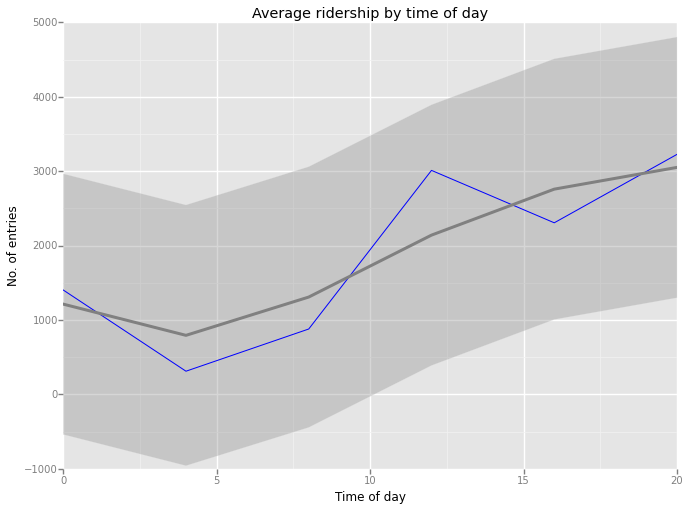

<ggplot: (8789789825909)>

In [210]:
q = """
select hour, avg(ENTRIESn_hourly) as entries
from data
group by hour
"""

time_of_day_data = pandasql.sqldf(q, locals())

ggplot(time_of_day_data, aes("hour", "entries")) + geom_line(color="blue") + stat_smooth(color="gray", size="3") + \
ggtitle('Average ridership by time of day') + \
xlab("Time of day") + ylab('No. of entries')

Chart above shows that average ridership is highest during the afternoon and lowest in the early morning.

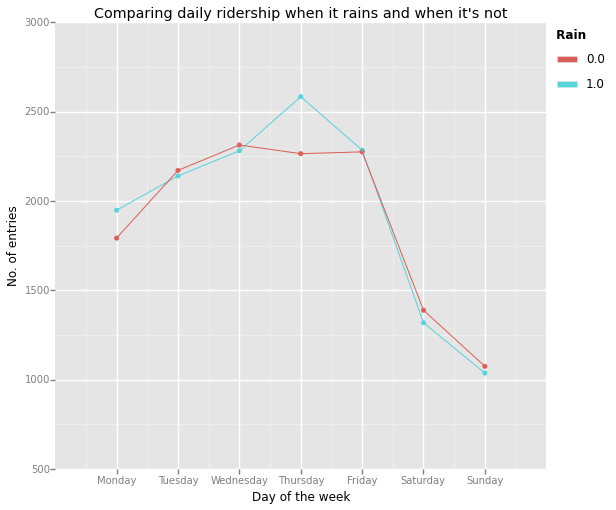

<ggplot: (8789789550293)>

In [211]:
q = """
select rain, day_week, avg(ENTRIESn_hourly) as entries
from data
group by day_week, rain
"""

rain_data = pandasql.sqldf(q, locals())

ggplot(rain_data, aes('day_week', 'entries', color='rain')) + geom_line() + geom_point() + \
ggtitle("Comparing daily ridership when it rains and when it's not") + \
ylab('No. of entries') + xlab('Day of the week') + \
scale_x_continuous(breaks=range(0,7), labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

We can see that there is no significant difference in the ridership during the week between the days in which there is rain and those where tere is no rain.  
The two graphs practically overlap in those two cases.

## Section 4. Conclusion

Please address the following questions in detail. Your answers should be 1-2 paragraphs long.

### Question 4.1
From your analysis and interpretation of the data, do more people ride the NYC subway when it is raining or when it is not raining?

#### Answer
Based on my analysis there is significant difference in ridership when it's raining vs. when it's not.  
Specifically, more people ride the subway when it rains.  

Based on my other observation like removing *rain* feature from my model did not change the value of R^2.  
So I cannot infer with definite certainty that rain affects ridership since my model is just as good at predicting the ridership without this extra feature.

### Question 4.2
What analyses lead you to this conclusion? You should use results from both your statistical tests and your linear regression to support your analysis.

#### Answer
First thing that led me to this conclusion was Mann-Whitney u-tests I performed on the dataset.  
These tests returned p value which was lower than p critical value and this led me to conclusion that rain has significant influence on the ridership.

Secondly, when performing linear regression and calculating R^2 - result did not change at all when including *rain* feature into the model.  
This in a way contradicts my earlier analysis so no definite inference can be drawn based on this observation.

## Section 5. Reflection

Please address the following questions in detail. Your answers should be 1-2 paragraphs long.

### Question 5.1
Please discuss potential shortcomings of the methods of your analysis, including:
- Dataset,
- Analysis, such as the linear regression model or statistical test.

#### Answer
Dataset:
- dataset covers only the month of May - other months can have different riderships
- dataset covers only one year - this may not be representative enough for every year
  
Analysis:
- we assume that the right approximation of our model is linear (hence the linear regression) when that doesn't need to be true
- R^2 value suggests that we didn't get particularly precise model - we only accounted for roughly half of data variation

### Question 5.2
(Optional) Do you have any other insight about the dataset that you would like to share with us?

#### Answer
There are many datapoints with ridership equal to zero for entire day which is perhaps only data missing and not ridership zero